## Assessing Machine Learning Models for Simple Carbonyl Classification

Abstract
---
The characterization of carbonyl compounds via spectroscopy is a classic yet fundamental exercise in learning organic chemistry. Both nuclear magnetic resonance and infrared spectroscopy are common techniques for structural elucidation, yet differentiating between similar carbonyl compounds can remain challenging. Here, a variety of machine learning models are evaluated on their ability to classify carbonyl compounds based on a small number of features. Logistic regression and random forest classifiers are shown to obtain poor classification accuracy (75%) with only two features. Expanding the number of features with random forests and artificial neural networks (ANNs) are subsequently demonstrated to improve classification accuracy considerably (nearly 90% accuracy), providing a reasonable framework for classification.

1.1 Introduction and Background
----

A fundamental aspect of organic chemistry is the structural elucidation of organic compounds. In early days, structural assignment was a tedious process, relying primarily on observations of physical properties (melting point, boiling point, morphology) and laborious degradation studies. The advent of modern spectroscopic techniques including Fourier-transform infrared (FT-IR) spectroscopy and, more notably, nuclear magnetic resonance (NMR) spectroscopy completely revolutionized the field, allowing for compounds to be structurally assigned within minutes instead of years.

Today, spectroscopy is an inseparable part of organic chemistry; a typical undergraduate course includes dedicated units on FT-IR and NMR for most common functional groups. Carbonyl compounds, in particular, receive considerable attention due the diagnostic nature of their absorption frequencies and chemical shifts. Students are typically taught "ranges" for particular functional group, using a combination of physical properties and spectroscopic properties to deduce and elucidate the chemical structure of unknowns. A primary challenge in this area, particularly for new students, is that subtle changes in peripheral chemical structure can result in significantly shifted resonance peaks. A variety of steric, electronic, and stereoelectronic effects can drastically alter the expected shift between two "similar" molecules.

<img src = "Images/carbonyl.jpg" width = 700>

From this perspective, an interesting question would be whether a machine learning (ML) algorithm could utilize a small set of physical and spectroscopic features (such as those available in an undergraduate organic laboratory) to confidently differentiate carbonyl compounds. Below, a variety of machine learning algorithms are assessed for creating a ML classifier based on a new dataset of 600 carbonyl compounds. 

1.2 Feature Selection and Dataset Retrieval
-----

Features were chosen as would be available in an undergraduate chemistry laboratory. FT-IR, 13C NMR, and mass spectrometry data can readily provide distinctive carbonyl shifts as well as an empirical chemical formula. Carbonyl groups are typically diagnostic due to both signal strength and resolution; a typical organic carbonyl FT-IR band appears in the 1600-1850 (cm-1) range, and is well resolved against other functional groups. The same is true for the 13C NMR signal, typically appearing in the 160 to 220 ppm range and well resolved against almost all other carbons in the same spectrum. Choosing these two as primary features, along with an empirical chemical formula (which is be deduced by mass spectrometry). Parsing the empirical formula to individual atom count (e.g. C2H4O ---> {"C":2, "H":4, "O":1} for the most common organic atoms creates additional features.

A final feature is a relative measure of unsaturation within a chemical structure. Since conjugated carbonyl compounds experience a significant upfield shift in both FT-IR and NMR. To capture this, the ratio of hydrogens to carbons "H to C" is generated as an additional feature.

To obtain homogeneous data (to eliminate variance introduced by collection of data across too many individual sources), spectral data was obtained from the Spectral Database for Organic Compounds (SDBS) is an online repository developed by and maintained the National Institute of Advanced Industrial Science and Technology (AIST), Japan. The repository holds six types of commonly-employed spectroscopic data for organic compound characterization, specifically: mass spectrometry (MS), proton and carbon nuclear magnetic resonance spectroscopy (1H and 13C NMR), Fourier-transform infrared spectroscopy (FT-IR), Raman spectroscopy (Raman), and electron spin resonance spectroscopy (ESR), with data collected in house conforming to institute protocol standards. The SDBS houses spectra from over 34,000 organic compounds (as of May, 2015) with detailed structural assignments where available.

From the SDBS, a dataset consisting of diagnostic carbonyl resonances from 13C NMR and FTIR spectra of 600 simple carbonyl compounds was retrieved from the SDBS, representing ketones, aldehydes, esters, amides, carboxylic acids, and acid chlorides (100 samples each). In this instance, "simple" refers to the a compound possessing one distinct carbonyl type (molecules containing two types, such as methylacetoacetate, are excluded due to ambiguity of labeling).

CAS registry, molecular, and SMILES strings were scraped from pubchempy.

In [1]:
import pandas as pd

# Load carbonyl datafile as Pandas dataframe
DATA_PATH = 'Data/carbonyl.csv'
carb_df = pd.read_csv(DATA_PATH)

# Show the first five rows
carb_df.head()

,Name,CAS,Formula,SMILES,Carbon,Infrared,Label
0,(+-)-2-chloropropionamide,27816-36-0,C3H6ClNO,CC(C(=O)N)Cl,172.9,1642,3
1,(+-)-2-methylbutyryl chloride,57526-28-0,C5H9ClO,CCC(C)C(=O)Cl,177.5,1793,5
2,(+-)-mevalonic acid delta-lactone,674-26-0,C6H10O3,CC1(CCOC(=O)C1)O,171.5,1721,2
3,(1R)-(-)-myrtenal,564-94-3,C10H14O,CC1(C2CC=C(C1C2)C=O)C,191.3,1679,1
4,(3-bromophenyl)acetic acid,1878-67-7,C8H7BrO2,C1=CC(=CC(=C1)Br)CC(=O)O,177.3,1698,4


Producing molecular structures from the included SMILES string is possible via the rdkit:

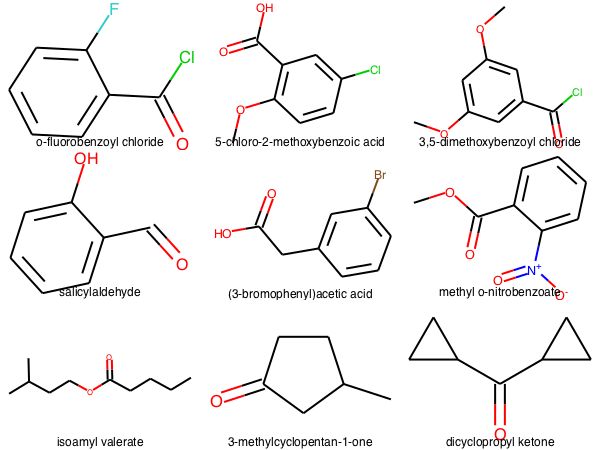

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=False

NO_SAMPLES = 9
samples = carb_df.sample(n = NO_SAMPLES)
samples.head()
Draw.MolsToGridImage([Chem.MolFromSmiles(i) for i in samples['SMILES']], 
                     molsPerRow=3,
                     subImgSize=(200,150),
                     legends=list(samples['Name']))

1.3 Data Visualization
-----

Data visualization was first performed as a seaborn pairplot; primarily on FT-IR and 13C NMR features to establish whether these features could be utilized to differentiate the carbonyl types. Notably, plotting 13C vs FTIR produces reasonable clusters; although considerable overlap in either dimension is present, moderate resolution appears to be present.


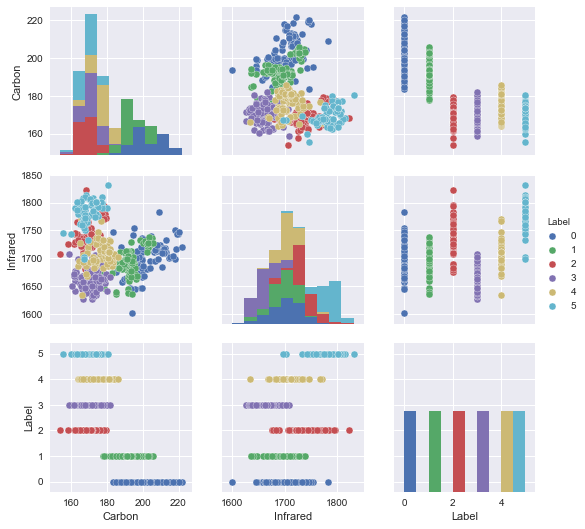

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

pairplot = sns.pairplot(carb_df[['Carbon','Infrared','Label']], hue='Label')

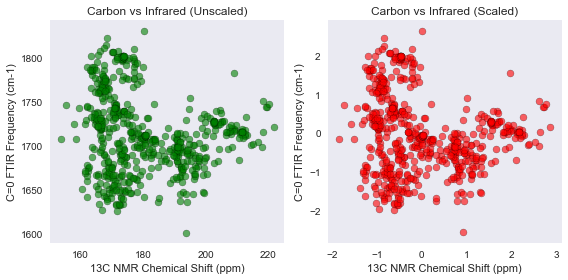

In [4]:
import numpy as np
import sklearn as sk
from sklearn import preprocessing


# Provide dictionary for label codes
LABEL_DICT = {0: 'ketone', 1: 'aldehyde', 2: 'ester', 3: 'amide', 4: 'acid', 5:'acid chloride'}

# Standardize Carbon and Infrared Features
std_scale = preprocessing.StandardScaler().fit(carb_df[['Carbon', 'Infrared']])
df_std = std_scale.transform(carb_df[['Carbon', 'Infrared']])

plt.figure('Scaled and Unscaled', figsize=(8,4))

# Unscaled carbon vs infrared plot
plt.subplot(1, 2, 1)
plt.scatter(carb_df['Carbon'],
            carb_df['Infrared'],
            color='green',
            edgecolor='black',
            alpha=0.6)

plt.title('Carbon vs Infrared (Unscaled)')
plt.xlabel('13C NMR Chemical Shift (ppm)')
plt.ylabel('C=0 FTIR Frequency (cm-1)')
plt.grid()
plt.tight_layout()

# standard-scaled carbon vs infrared
plt.subplot(1, 2, 2)
plt.scatter(df_std[:,0],
            df_std[:,1],
            color='red',
            edgecolor='black',
            alpha=0.6)

plt.title('Carbon vs Infrared (Scaled)')
plt.xlabel('13C NMR Chemical Shift (ppm)')
plt.ylabel('C=0 FTIR Frequency (cm-1)')
plt.grid()
plt.tight_layout()